# An Improved KNN Based on Class Contribution and Feature Weighting

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import operator

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import mean
from collections import defaultdict

In [2]:
#fungsi buat dapetin jarak eucledian
#data1 = data pertama
#data2 = data pembanding
#length = jumlah variabel yang dibandingkan
def eucledianDistance(data1, data2, length, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    distance = 0
    for x in range(length):
        distance += (weight[x]*pow((float(data1[x]) - float(data2[x])), 2))
        # print(str(data1) + "-" + str(data2) + ": " + str(distance))
    return math.sqrt(distance)

In [3]:
#fungsi untuk mendapatkan tetangga terdekat
#trainingset = data training / ground truth
#testdata = data testing / data yang diuji
#k = tetangga
def getNeighbors(trainingSet, testData, testClass, k, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    #array distance untuk nyimpan jarak, nanti akan disort yang tedekat
    # print(len(testData))
    distance = []
    length = len(testData) - 1
    for x in range(len(trainingSet)):
        dist = eucledianDistance(testData, trainingSet[x], length)
        distance.append((trainingSet[x], testClass[x], dist))
        # print((trainingSet[x], dist))
    distance.sort(key=operator.itemgetter(2))
    #print(distance)
    neighbors = []
    for x in range(k):
        #habis disort, data tetangga terdekat disimpan di array neighbors
        neighbors.append(distance[x][0:2])
#     print(neighbors)
    return neighbors

In [4]:
def getNeighborsDCT(trainingSet, testData, testClass, k, weight):
    #array distance untuk nyimpan jarak, nanti akan disort yang tedekat
    # print(len(testData))
    distance = []
    length = len(testData) - 1
    for x in range(len(trainingSet)):
        dist = eucledianDistance(testData, trainingSet[x], length, weight)
        distance.append((trainingSet[x], testClass[x], dist))
        # print((trainingSet[x], dist))
    distance.sort(key=operator.itemgetter(2))
    # print(distance)
    neighbors = []
    for x in range(k):
        #habis disort, data tetangga terdekat disimpan di array neighbors
        neighbors.append(distance[x][0:3])
    # print(neighbors)
    return neighbors

In [5]:
#fungsi getResponse buat nyari datatest masuk kelas mana / voting kelasnya
def getResponse(neighbors):
    #classvote disiapin buat penampung proses voting kelas
    classVote = {}
    # print(neighbors)
    for x in range(len(neighbors)):
#         print(neighbors[x][-1])
#         print(type(neighbors[x]))
        response = neighbors[x][-1]
        # print(response)
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
    # print(classVote)
    # sortedVotes buat milih vote kelas terbanyak
#     print("classVote")
#     print(classVote)
    sortedVotes = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    # print(sortedVotes[0][0])
    return sortedVotes[0][0]

In [6]:
def getResponseDCT(neighbors):
    #classvote disiapin buat penampung proses voting kelas
    classVote = {}
    sumDistance = {}
    # print(neighbors)
    for x in range(len(neighbors)):
#         print(neighbors[x][-1])
#         print(type(neighbors[x]))
        response = neighbors[x][-2]
        # print(response)
        if response in classVote:
            classVote[response] += 1
            sumDistance[response] += neighbors[x][-1]
        else:
            classVote[response] = 1
            sumDistance[response] = neighbors[x][-1]
    # print(classVote)
    # sortedVotes buat milih vote kelas terbanyak
#     sortedVotes = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    # print(sortedVotes[0][0])
    
    return classVote, sumDistance

In [7]:
#fungsi getAccuracy untuk mendapatkan nilai akurasi
#testData adalah kelas dari data yang dicek
#prediction adalah prediksi kelas dari data yang dicek
def getAccuracy(testData, predictions):
    correct = 0
#     print(len(testData))
#     print(len(predictions))
    for x in range(len(testData)):
        #jika prediksi benar, maka nilai correct bertambah +1
        if testData[x] == predictions[x]:
            correct += 1
    #mengembalikan nilai return persentase
#    print(correct)
    return (correct/float(len(testData)))

In [8]:
def KNN(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):
    neighbors = getNeighbors(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour)
    result = getResponse(neighbors)
    neighbors.clear()
    return result

In [9]:
def DCT_KNN(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight):
    neighbors = getNeighborsDCT(KF_xtrain, KF_xtest, KF_ytrain, numberofNeighbour, weight)
    classVote, sumDistance = getResponseDCT(neighbors)
    CT = []
#     print(classVote, sumDistance)
    for x in (classVote):
        CT.append((numberofNeighbour/classVote[x])+((1/classVote[x])*sumDistance[x]))
#     print(CT)
#     print(list(classVote.keys())[CT.index(min(CT))])
    return list(classVote.keys())[CT.index(min(CT))]

In [10]:
#fungsi getKFold untuk melakukan operasi K-Fold dan return accuracy
def getKFold(dataX, dataY, numberofK, numberofNeighbour, method, weight=[1,1,1,1,1,1,1,1,1,1,1,1]):    
    prediction = []
    fold = 1
    KF_xtrain = []
    KF_xtest = []
    KF_ytrain = []
    KF_ytest = []
    knn_result = []
    kfold = KFold(n_splits=numberofK, shuffle=True, random_state=True)
    for train, test in kfold.split(dataX, dataY):
        # print('train: %s, test: %s' % (X[train], X[test]))
        KF_xtrain.append(dataX[train])
        KF_xtest.append(dataX[test])
        KF_ytrain.append(dataY[train])
        KF_ytest.append(dataY[test])
        for j in range(len(KF_xtest[0])):
            if method == "KNN":
                prediction.append(KNN(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], numberofNeighbour))
            elif method == "DCT-KNN":
                prediction.append(DCT_KNN(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], numberofNeighbour, weight))
        accuracy = getAccuracy(KF_ytest[0], prediction)
        knn_result.append(accuracy)
        prediction.clear()
        # print(y_test)
        # print(prediction)
        fold += 1
        KF_xtest.clear()
        KF_xtrain.clear()
        KF_ytest.clear()
        KF_ytrain.clear()
    print('K = ' + str(numberofK) + ' Neighbour = ' + str(numberofNeighbour)+ ' Accuracy: ' + str(mean(knn_result)))
    return mean(knn_result)
    

In [12]:
namesIris = [
    'sepal-length',
    'sepal-width',
    'petal-width',
    'petal-length',
    'class'
]

nameTransfusion = [
    'Recency',
    'Frequency',
    'Monetary',
    'Time',
    'Yes/No Donate'
]

nameBupa = [
    'mcv',
    'alkphos',
    'sgpt',
    'sgot',
    'gammagt',
    'drinks',
    'selector'
]

## Iris Dataset

In [11]:
#Load dataset
path = "dataset/iris.data"
# path = "dataset/transfusion.data"
# path = "dataset/bupa.data"

In [13]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

150


In [14]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
#print(X)
#print(Z)

In [15]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    normal_KNN_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    for k in range (4):
        lack_feature_result[k].append(getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN"))
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

K = 5 Neighbour = 3 Accuracy: 0.9466666666666667
K = 5 Neighbour = 3 Accuracy: 0.9400000000000001
K = 5 Neighbour = 3 Accuracy: 0.9666666666666667
K = 5 Neighbour = 3 Accuracy: 0.72
K = 5 Neighbour = 3 Accuracy: 0.72
K = 5 Neighbour = 5 Accuracy: 0.9400000000000001
K = 5 Neighbour = 5 Accuracy: 0.9400000000000001
K = 5 Neighbour = 5 Accuracy: 0.9400000000000001
K = 5 Neighbour = 5 Accuracy: 0.76
K = 5 Neighbour = 5 Accuracy: 0.76
K = 5 Neighbour = 7 Accuracy: 0.9400000000000001
K = 5 Neighbour = 7 Accuracy: 0.9533333333333334
K = 5 Neighbour = 7 Accuracy: 0.9466666666666667
K = 5 Neighbour = 7 Accuracy: 0.74
K = 5 Neighbour = 7 Accuracy: 0.74


In [16]:
disc = []
for i in range (4):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (4):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.19176319176319173, 0.18790218790218788, 0.31016731016731025, 0.31016731016731025]


In [20]:
#5 Fold
KNN_5_result = []
DCTKNN_5_result = []
for N in range (1,6):
    KNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    DCTKNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))


K = 5 Neighbour = 1 Accuracy: 0.92
K = 5 Neighbour = 1 Accuracy: 0.9266666666666666
K = 5 Neighbour = 2 Accuracy: 0.92
K = 5 Neighbour = 2 Accuracy: 0.9266666666666666
K = 5 Neighbour = 3 Accuracy: 0.9466666666666667
K = 5 Neighbour = 3 Accuracy: 0.9466666666666667
K = 5 Neighbour = 4 Accuracy: 0.9400000000000001
K = 5 Neighbour = 4 Accuracy: 0.9400000000000001
K = 5 Neighbour = 5 Accuracy: 0.9400000000000001
K = 5 Neighbour = 5 Accuracy: 0.9400000000000001


In [18]:
#10 Fold

KNN_10_result = []
DCTKNN_10_result = []
for N in range (1,11):
    KNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="KNN"))
    DCTKNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))

K = 10 Neighbour = 1 Accuracy: 0.92
K = 10 Neighbour = 1 Accuracy: 0.9333333333333333
K = 10 Neighbour = 2 Accuracy: 0.92
K = 10 Neighbour = 2 Accuracy: 0.9333333333333333
K = 10 Neighbour = 3 Accuracy: 0.9466666666666667
K = 10 Neighbour = 3 Accuracy: 0.9400000000000001
K = 10 Neighbour = 4 Accuracy: 0.9333333333333333
K = 10 Neighbour = 4 Accuracy: 0.9333333333333333
K = 10 Neighbour = 5 Accuracy: 0.9466666666666667
K = 10 Neighbour = 5 Accuracy: 0.9466666666666667
K = 10 Neighbour = 6 Accuracy: 0.9400000000000001
K = 10 Neighbour = 6 Accuracy: 0.9466666666666667
K = 10 Neighbour = 7 Accuracy: 0.9333333333333333
K = 10 Neighbour = 7 Accuracy: 0.9333333333333333
K = 10 Neighbour = 8 Accuracy: 0.9466666666666667
K = 10 Neighbour = 8 Accuracy: 0.9466666666666667
K = 10 Neighbour = 9 Accuracy: 0.9466666666666667
K = 10 Neighbour = 9 Accuracy: 0.9466666666666667
K = 10 Neighbour = 10 Accuracy: 0.9466666666666667
K = 10 Neighbour = 10 Accuracy: 0.9466666666666667


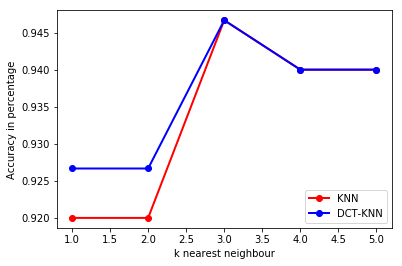

In [21]:
plt.plot([1,2,3,4,5],KNN_5_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5],DCTKNN_5_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

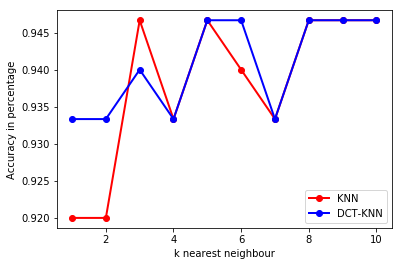

In [22]:
plt.plot([1,2,3,4,5,6,7,8,9,10],KNN_10_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5,6,7,8,9,10],DCTKNN_10_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

## Blood Dataset

In [25]:
#Load dataset
# path = "dataset/iris.data"
path = "dataset/transfusion.data"
# path = "dataset/bupa.data"

In [26]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

748


In [28]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
#print(X)
#print(Z)

In [29]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    normal_KNN_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    for k in range (4):
        lack_feature_result[k].append(getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN"))
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

K = 5 Neighbour = 3 Accuracy: 0.7058970917225951
K = 5 Neighbour = 3 Accuracy: 0.5803042505592841
K = 5 Neighbour = 3 Accuracy: 0.7058970917225951
K = 5 Neighbour = 3 Accuracy: 0.719248322147651
K = 5 Neighbour = 3 Accuracy: 0.719248322147651
K = 5 Neighbour = 5 Accuracy: 0.7353646532438479
K = 5 Neighbour = 5 Accuracy: 0.6016733780760626
K = 5 Neighbour = 5 Accuracy: 0.7353646532438479
K = 5 Neighbour = 5 Accuracy: 0.7406353467561522
K = 5 Neighbour = 5 Accuracy: 0.7406353467561522
K = 5 Neighbour = 7 Accuracy: 0.7379776286353468
K = 5 Neighbour = 7 Accuracy: 0.6177091722595078
K = 5 Neighbour = 7 Accuracy: 0.7379776286353468
K = 5 Neighbour = 7 Accuracy: 0.745923937360179
K = 5 Neighbour = 7 Accuracy: 0.745923937360179


In [30]:
disc = []
for i in range (4):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (4):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.31886728841289247, 0.23113819271650976, 0.22499725943529889, 0.22499725943529889]


In [31]:
#5 Fold
KNN_5_result = []
DCTKNN_5_result = []
for N in range (1,6):
    KNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    DCTKNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))


K = 5 Neighbour = 1 Accuracy: 0.6176107382550335
K = 5 Neighbour = 1 Accuracy: 0.6176107382550335
K = 5 Neighbour = 2 Accuracy: 0.6176107382550335
K = 5 Neighbour = 2 Accuracy: 0.6176107382550335
K = 5 Neighbour = 3 Accuracy: 0.7058970917225951
K = 5 Neighbour = 3 Accuracy: 0.7018881431767338
K = 5 Neighbour = 4 Accuracy: 0.7178970917225951
K = 5 Neighbour = 4 Accuracy: 0.7152304250559284
K = 5 Neighbour = 5 Accuracy: 0.7353646532438479
K = 5 Neighbour = 5 Accuracy: 0.7179328859060403


In [32]:
#10 Fold

KNN_10_result = []
DCTKNN_10_result = []
for N in range (1,11):
    KNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="KNN"))
    DCTKNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))

K = 10 Neighbour = 1 Accuracy: 0.6162162162162163
K = 10 Neighbour = 1 Accuracy: 0.6162162162162163
K = 10 Neighbour = 2 Accuracy: 0.6162162162162163
K = 10 Neighbour = 2 Accuracy: 0.6162162162162163
K = 10 Neighbour = 3 Accuracy: 0.7257657657657658
K = 10 Neighbour = 3 Accuracy: 0.7244684684684685
K = 10 Neighbour = 4 Accuracy: 0.7205045045045045
K = 10 Neighbour = 4 Accuracy: 0.7204864864864865
K = 10 Neighbour = 5 Accuracy: 0.7431531531531531
K = 10 Neighbour = 5 Accuracy: 0.7364864864864865
K = 10 Neighbour = 6 Accuracy: 0.7391711711711711
K = 10 Neighbour = 6 Accuracy: 0.7364864864864865
K = 10 Neighbour = 7 Accuracy: 0.7445045045045046
K = 10 Neighbour = 7 Accuracy: 0.7458558558558559
K = 10 Neighbour = 8 Accuracy: 0.7404864864864865
K = 10 Neighbour = 8 Accuracy: 0.7512072072072072
K = 10 Neighbour = 9 Accuracy: 0.7405045045045046
K = 10 Neighbour = 9 Accuracy: 0.7418558558558559
K = 10 Neighbour = 10 Accuracy: 0.7498738738738738
K = 10 Neighbour = 10 Accuracy: 0.747225225225225

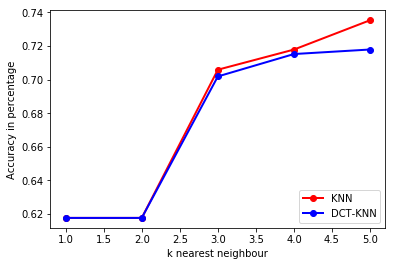

In [33]:
plt.plot([1,2,3,4,5],KNN_5_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5],DCTKNN_5_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

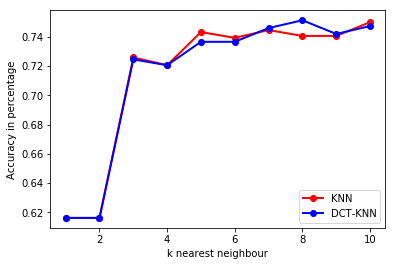

In [34]:
plt.plot([1,2,3,4,5,6,7,8,9,10],KNN_10_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5,6,7,8,9,10],DCTKNN_10_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

## Liver Dataset

In [35]:
#Load dataset
# path = "dataset/iris.data"
# path = "dataset/transfusion.data"
path = "dataset/bupa.data"

In [36]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

345


In [37]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values
Z_0 = np.delete(X, 0, 1)
Z_1 = np.delete(X, 1, 1)
Z_2 = np.delete(X, 2, 1)
Z_3 = np.delete(X, 3, 1)
Z_4 = np.delete(X, 4, 1)
Z_5 = np.delete(X, 5, 1)
#print(X)
#print(Z)

In [38]:
# 1. Delete one feature
# pret is the sum average accuracy of
# the traditional kNN algorithm in the original dataset when
# the value of k is 3,5 and 7 on the condition of 5-folder cross
# validation, and the prei is the similar sum of the traditional
# kNN algorithm on the data lacking the i-th feature.
normal_KNN_result = []
lack_feature_result = defaultdict(list)
z = {}

for N in (3, 5, 7):
    normal_KNN_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    for k in range (6):
        lack_feature_result[k].append(getKFold(locals()["Z_" + str(k)], Y, numberofK=5, numberofNeighbour=N, method="KNN"))
        
# print(normal_KNN_result)
# for k in range (4):
#     print(lack_feature_result[k])

K = 5 Neighbour = 3 Accuracy: 0.6347826086956522
K = 5 Neighbour = 3 Accuracy: 0.6086956521739131
K = 5 Neighbour = 3 Accuracy: 0.6086956521739131
K = 5 Neighbour = 3 Accuracy: 0.5652173913043478
K = 5 Neighbour = 3 Accuracy: 0.6202898550724637
K = 5 Neighbour = 3 Accuracy: 0.6260869565217391
K = 5 Neighbour = 3 Accuracy: 0.6260869565217391
K = 5 Neighbour = 5 Accuracy: 0.6318840579710145
K = 5 Neighbour = 5 Accuracy: 0.6347826086956522
K = 5 Neighbour = 5 Accuracy: 0.6347826086956522
K = 5 Neighbour = 5 Accuracy: 0.6144927536231883
K = 5 Neighbour = 5 Accuracy: 0.6318840579710144
K = 5 Neighbour = 5 Accuracy: 0.5942028985507246
K = 5 Neighbour = 5 Accuracy: 0.5942028985507246
K = 5 Neighbour = 7 Accuracy: 0.672463768115942
K = 5 Neighbour = 7 Accuracy: 0.6492753623188406
K = 5 Neighbour = 7 Accuracy: 0.6869565217391305
K = 5 Neighbour = 7 Accuracy: 0.6115942028985507
K = 5 Neighbour = 7 Accuracy: 0.6608695652173913
K = 5 Neighbour = 7 Accuracy: 0.591304347826087
K = 5 Neighbour = 7 Ac

In [40]:
disc = []
for i in range (6):
    disc.append((1-(sum(lack_feature_result[i]) - sum(normal_KNN_result))))
# print(disc)
normalized_disc = []
for i in range (6):
    normalized_disc.append((disc[i]/sum(disc)))
print(normalized_disc)

[0.16137684398748325, 0.15556548949485918, 0.17702279839070184, 0.15824765310683953, 0.17389360751005808, 0.17389360751005808]


In [41]:
#5 Fold
KNN_5_result = []
DCTKNN_5_result = []
for N in range (1,6):
    KNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="KNN"))
    DCTKNN_5_result.append(getKFold(X, Y, numberofK=5, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))


K = 5 Neighbour = 1 Accuracy: 0.591304347826087
K = 5 Neighbour = 1 Accuracy: 0.5884057971014492
K = 5 Neighbour = 2 Accuracy: 0.591304347826087
K = 5 Neighbour = 2 Accuracy: 0.5884057971014492
K = 5 Neighbour = 3 Accuracy: 0.6347826086956522
K = 5 Neighbour = 3 Accuracy: 0.6115942028985507
K = 5 Neighbour = 4 Accuracy: 0.6028985507246376
K = 5 Neighbour = 4 Accuracy: 0.6173913043478261
K = 5 Neighbour = 5 Accuracy: 0.6318840579710145
K = 5 Neighbour = 5 Accuracy: 0.6492753623188405


In [42]:
#10 Fold

KNN_10_result = []
DCTKNN_10_result = []
for N in range (1,11):
    KNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="KNN"))
    DCTKNN_10_result.append(getKFold(X, Y, numberofK=10, numberofNeighbour=N, method="DCT-KNN", weight = normalized_disc))

K = 10 Neighbour = 1 Accuracy: 0.5969747899159664
K = 10 Neighbour = 1 Accuracy: 0.5969747899159664
K = 10 Neighbour = 2 Accuracy: 0.5969747899159664
K = 10 Neighbour = 2 Accuracy: 0.5969747899159664
K = 10 Neighbour = 3 Accuracy: 0.6260504201680672
K = 10 Neighbour = 3 Accuracy: 0.614453781512605
K = 10 Neighbour = 4 Accuracy: 0.6173109243697479
K = 10 Neighbour = 4 Accuracy: 0.6289915966386554
K = 10 Neighbour = 5 Accuracy: 0.6491596638655462
K = 10 Neighbour = 5 Accuracy: 0.6491596638655462
K = 10 Neighbour = 6 Accuracy: 0.6518487394957984
K = 10 Neighbour = 6 Accuracy: 0.6635294117647059
K = 10 Neighbour = 7 Accuracy: 0.6725210084033614
K = 10 Neighbour = 7 Accuracy: 0.6636134453781513
K = 10 Neighbour = 8 Accuracy: 0.6694117647058824
K = 10 Neighbour = 8 Accuracy: 0.6752100840336135
K = 10 Neighbour = 9 Accuracy: 0.6810924369747899
K = 10 Neighbour = 9 Accuracy: 0.6663865546218488
K = 10 Neighbour = 10 Accuracy: 0.6551260504201681
K = 10 Neighbour = 10 Accuracy: 0.6577310924369748

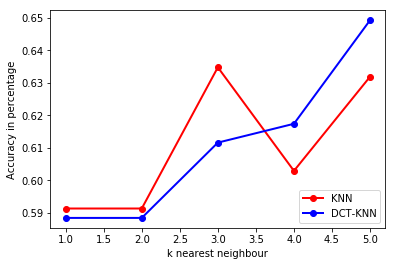

In [43]:
plt.plot([1,2,3,4,5],KNN_5_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5],DCTKNN_5_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

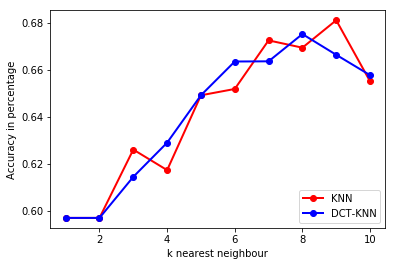

In [44]:
plt.plot([1,2,3,4,5,6,7,8,9,10],KNN_10_result,'-ro', label="KNN", linewidth=2.0)
plt.plot([1,2,3,4,5,6,7,8,9,10],DCTKNN_10_result,'-bo', label="DCT-KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()